# Optimizing neurally diverse architectures for small and imbalanced subsets of MNIST  

* This notebook is for exploring architectural specifications for neurally diverse architectures on a small and imbalanced version of MNIST.
* The architecture includes pre-branch, branch, and post-branch segments. Neural diversity is implemented specifically at the level of activation function non-linearity and a small wet of "connection functions" (i.e. linear, identity, and element-wise scaling).
* A highly simplistic form of architectural search based on stochastic hill-climbing with some differential search is included, for your reference.
* 0.3.7 - added id and elementwise scaling weight functions.
* 0.3.8 - added training acuracies; do_train is now returning the model with the best validation error.
* 0.3.9 - added basic DropCircuit.

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Data extraction trial 0.
Initializing population ...
 - Distance between pop[0] and pop[1]: 179.31
 - Distance between pop[0] and pop[2]: 186.57
 - Distance between pop[0] and pop[3]: 212.89
 - Distance between pop[0] and pop[4]: 201.54
 - Distance between pop[0] and pop[5]: 226.13
 - Distance between pop[0] and pop[6]: 171.12
 - Distance between pop[0] and pop[7]: 219.08
 - Distance between pop[0] and pop[8]: 163.23
 - Distance between pop[0] and pop[9]: 240.26
Average population distance: 180.01
Population distance sum: 1800.13


---------------GA----------------




/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:786: RuntimeWarning: divide by zero encountered in double_scalars


Streaming output truncated to the last 5000 lines.
 * New chromosome has been rejected.
     ----> New fitness: 34.40 Old fitness: 77.20 Distance 6.92
     ----> New chrom's distance from best_chromosomes[0]: 6.92
 * New chromosome has been rejected.
     ----> New fitness: 25.30 Old fitness: 77.20 Distance 6.87
     ----> New chrom's distance from best_chromosomes[0]: 6.87
 * New chromosome has been rejected.

 ******** self.best_chromosomes[0] selected due to non-improving search.
_____________________________________________________________

Temperature 0.004128
Current chromosome's fitness: 77.20
Neighbour range: 0.007200
Floating point precision: 33
Max distance: 10.27 Min distance: 0.03

 ----> Current best: 76.10
 ----> SA have not improved for 0 iterations
 ----> Current chromosome has been changed 68 times due to non-improving search
_____________________________________________________________

  ----> create_neighbours() took 5 iterations
  ----> We have tabu dictionary of l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1818: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1818: RuntimeWarning: invalid value encountered in true_divide


Streaming output truncated to the last 5000 lines.
     de_r_gene_lower: 33


     ----> Offset mutation distance from differential: 0.11
     ----> Child fitness: 73.10 Current fitness: 75.10 Distance 5.47
     ----> Current chrom's distance from best_chromosomes[0]: 0.00
     ----> List of best chromosomes: [77.4, 77.2, 76.8, 76.7, 76.6, 76.5, 76.4, 76.3, 76.2, 76.1]

     ----> Offset mutation distance from differential: 0.21
     ----> Child fitness: 74.20 Current fitness: 73.80 Distance 3.42
     ----> Current chrom's distance from best_chromosomes[1]: 0.00
     ----> List of best chromosomes: [77.4, 77.2, 76.8, 76.7, 76.6, 76.5, 76.4, 76.3, 76.2, 76.1]

     ----> Offset mutation distance from differential: 0.12
     ----> Child fitness: 73.40 Current fitness: 74.90 Distance 4.56
     ----> Current chrom's distance from best_chromosomes[2]: 0.00
     ----> List of best chromosomes: [77.4, 77.2, 76.8, 76.7, 76.6, 76.5, 76.4, 76.3, 76.2, 76.1]

     ----> Offset mutation distance f

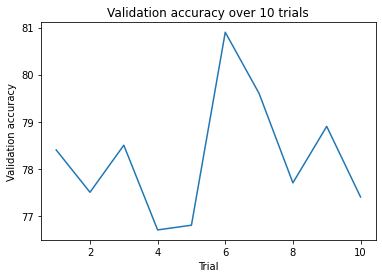

In [2]:
from __future__ import print_function

version = '_v0p3p9_'

import time
import math
import random as rand
from random import random, randrange, sample, randint
# Used for calculating Canberra distance.
from scipy.spatial import distance
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import datasets

import csv
import torch
import numpy as np
from torch.utils import data
import copy


from datetime import datetime
from google.colab import drive

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# ===============
# Parameters
# ===============

# --- General framework arguments

args = {}
kwargs = {}
args['num_train_batch'] = 1  # number of MNIST training batches
args['num_valid_batch'] = 10  # number of MNIST validation batches
args['train_batch_size'] = 100  # training batch size
args['valid_batch_size'] = 100  # validation batch size
args['test_batch_size'] = 10
# args['epochs'] = 100  # number of training epochs
args['lr'] = 1  # 0.1  # 0.01 # learning rate # this is over-written by the solution
args[
    'momentum'] = 0.5  # SGD momentum (default: 0.5); momentum is a moving average of our gradients (helps keep a useful direction)
args['clip_level'] = 0.5  # gradient clip threshold
args['seed'] = 1  # random seed
args['log_interval_epoch'] = 1  # display training loss every log_int... epochs
args['cuda'] = True
args['patience'] = 1000  # stop train. if the valid. err. hasn't improved by this num. of epochs
args['noise_in'] = -1  # 0.5  # 0.15  # amount of noise to add to the training data
args['noise_out'] = -1  # probability of changing an output label to some random label
args['verbose_train'] = False  # print status of model training?
args['verbose_meta'] = True  # print status of architecture optimization?
args['min_inst_class'] = 5  # minimum number of instances per class in the training set
args['batch_max_tries'] = 10  # max. num. of attempts in extracting data batches
args['save_best_chrom'] = True  # False  # save the best chromose in Google Drive?
args['dc_prob_drop'] = 0.5  # 0.5 # probability of dropping a circuit (DropCircuit)
args['prob_sel_branch'] = 0.5  # probability of architectural search selecting/using a branch (this is not DropCircuit)

# --- Neural architectural limits

args['num_epochs_search'] = 10  # 100  # number of epochs for training during architecture search
args['num_epochs_test'] = 1000  # num. epochs for training during the final test
limits = {}
limits['min_layer_nodes'] = 10  # 5 # 50
limits['max_layer_nodes'] = 100
limits['max_pre_branch_layers'] = 5  # 3
limits['max_branches'] = 10
limits['max_branch_layers'] = 5  # 3
limits['max_post_branch_layers'] = 5  # 3
limits['lr1_min'] = 0.001
limits['lr1_,max'] = 2
limits['lr2_min'] = 0.001
limits['lr2_,max'] = 2
limits['moment_min'] = 0.001
limits['moment_max'] = 1

# --- Architectural search parameters
meta = {}

def initialize_meta():

    # Fitness from which ANN is considered to be converged.
    meta['convergence_fitness'] = 70
    # Distance gap can't be smaller between first and every other chromosome in the initial population.
    meta['pop_dist_threshold'] = 6

    # Differential Evolution Algorithm
    meta['pop_count'] = 10  # Size of the population in GE/DE. (Number of individuals)
    meta['evol_iter'] = 30  # Number of different ial evolution iterations.
    meta['mut_factor'] = 0.015  # Mutation factor that is used in DE mutation.
    meta['p_crossover_de'] = 0.9  # Crossover probability (if rand < p_crossover --> do crossover)
    # Fraction of population that will be filled with best chromosome after PSO search.
    meta['de_filled_population_fraction'] = 1
    # Percent of population filled with best chromosomes after 1st half.
    meta['de_1st_half_fill_factor'] = 0.5
    meta['de_r_offser_lower'] = -0.011 # Lower bound of the offset that we generate during DE mutation.
    meta['de_r_offser_upper'] = 0.011  # Upper bound of the offset that we generate during DE mutation.
    meta['de_r_gene_lower'] = 65 # Lower bound of random amount of genes we mutate during DE mutation.
    meta['de_r_gene_upper'] = 370 # Upper bound of random amount of genes we mutate during DE mutation.
    meta['de_non_improvement_t'] = 18 # After this threshold of non-improvement iterations we will perform SA.
    meta['de_prob_sa'] = 0.2 # Probability of executing SA if DE is not improving for iteration threshold.
    meta['de_max_distance'] = 50 # Maximum distance between mutated and current chromosome.

    # Genetic Algorithm
    meta['retain'] = 0.4  # Part of population that we want to keep in next population of GA.
    meta['random_select'] = 0.1  # Probability of retaining rejected chromosome.
    meta['ga_no_of_children'] = 2  # Number of children that we create during recombination in GA.
    meta['GA_iterations'] = 30  # Number of GA iterations.
    meta['p_crossover_ga'] = 0.6 # Crossover probability (if rand < p_crossover --> do crossover)

    meta['ga_exploitation_iter'] = 20 # After specified amount of iterations we boost exploitation.

    meta['random_threshold_lower'] = 0.19 # Lower bound on random threshold used in mutation.
    meta['random_threshold_upper'] = 0.8 # Upper bound on random threshold used in mutation.

    # After specified number of iterations ANN should converge, if not boost exploration.
    meta['ga_convergence_iter'] = 10
    meta['tournament_size'] = 3 # Size of the tournament during tournament selection reproduction.


    # Simulated Annealing
    meta['sa_g_mutation_count'] = 30 # Amount of genes mutated during SA iteration.
    meta['sa_stopping_T'] = 1e-5 # Defines when we stop our search.
    meta['sa_alpha'] = 0.87 # Coefficient by which temperature will be decreased.
    meta['sa_floating_point_tabu'] = 1 # Floating point number rounding for tabu list.

    meta['sa_neighbour_range'] = 0.04 # Neighbour range for SA, decreased with temperature.
    meta['sa_num_neighbours'] = 5 # Neighbourhood size during SA search.
    meta['sa_neighbour_range_decrease'] = 0.0004 # Number that we subtract from neighbour range each iter.

    # Once we hit threshold of non-improving iterations, we pick best not the most recent chrom.
    meta['sa_non_improvement_threshold'] = 3
    meta['sa_max_iterations'] = 3 # We do not allow more SA search calls.

    # Particle Swarm Optimization (PSO)
    meta['pso_iterations'] = 15
    meta['pso_inertia'] = 0.72984 # How much to weigh the previous velocity, range is 0-1, typically very close to 1.
    meta['pso_cognitive'] = 2.05 # Typically around 2, can range from 0-4
    meta['pso_social'] = 2.05 # Typically around 2, can range from 0-4
    # We stop executing PSO search after fitness with iteration threshold is achieved.
    meta['pso_iteration_threshold'] = 5
    meta['pso_fitness_threshold'] = 74
    # Fraction of population that will be filled with best chromosome after GA search.
    meta['pso_filled_population_fraction'] = 1


num_train_instances = args['num_train_batch'] * args['train_batch_size']
num_valid_instances = args['num_valid_batch'] * args['valid_batch_size']

data_rand_seed = 1  # (other pre-tested seeds: 2, 3)


# Check whether we have enough instances per class
# We want an imbalanced dataset but we don't want any specific label having
# an "insufficient" number of instances.
def check_enough_inst(batches, min_inst_per_class):
    # Concatenate training batch output labels
    labels = batches[0][1].numpy()
    for batch_i in range(1, args['num_train_batch']):
        new_labels = batches[batch_i][1].numpy()
        labels = np.concatenate((labels, new_labels))

    labels = labels.tolist()

    # Scan though labels
    for a_label in range(10):  # assuming MNIST, of course
        a_count = labels.count(a_label)
        # If label count is < min_inst_per_class return False
        if a_count < min_inst_per_class:
            return False

    # Return True
    return True


# Prepare data. Extract training and validation batches
# This is where we make the problem "small and imbalanced"
def extract_batches(a_loader, min_inst_per_class, max_tries):
    # Keep trying until you have a required minimum number of instances
    # per class in the training set (not elegant but ok for the range of
    # "min_inst_per_class" we need)

    for ti in range(max_tries):

        print('Data extraction trial {}.'.format(ti))

        # Initializations
        train_batches = []
        valid_batches = []
        tot_batch_extract = args['num_train_batch'] + args['num_valid_batch']

        # Extract
        for batch_idx, (data, target) in enumerate(a_loader):

            if batch_idx < args['num_train_batch']:
                train_batches.append((data, target))
            else:
                valid_batches.append((data, target))
                if batch_idx == tot_batch_extract - 1:
                    break

        # Check minimum number of instances
        enough_instaces = check_enough_inst(train_batches, min_inst_per_class)
        if enough_instaces:
            return train_batches, valid_batches

    print('It was not possible to create a dataset.')
    print('Consider increasing the overall number of instances, or')
    print('decreasing the minimum instances per class allowed.')
    return [], []


# # ==========================
# # Display dataset
# # ==========================
#
# # This is not currently used
#
# # Display MNIST instances
# # Adapted from # https://github.com/CSCfi/machine-learning-scripts/blob/master/notebooks/pytorch-mnist-mlp.ipynb
def disp_MNIST_inst(num_disp, X_train, y_train):
    pltsize = 1
    plt.figure(figsize=(num_disp * pltsize, pltsize))
    for i in range(num_disp):
        plt.subplot(1, num_disp, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i, :, :].numpy().reshape(28, 28), cmap="gray_r")
        plt.title('Class: ' + str(y_train[i].item()))


# Simple function to scale parameters
# num is assume to be \in [0,1]
def scale_to_range(num, min_val, max_val):
    range = max_val - min_val
    return (num * range) + min_val


# Simple layer for doing elementwise scaling
# Adapated from https://stackoverflow.com/questions/51980654/pytorch-element-wise-filter-layer
class Elem_Scaling_1D(nn.Module):
    def __init__(self, num_nodes, bogus):  # clean-up "bogus"
        super(Elem_Scaling_1D, self).__init__()
        # Initialize
        init_weights = np.random.normal(loc=0, scale=0.5, size=np.shape(num_nodes))
        # Assign
        self.weights = torch.from_numpy(init_weights)
        # self.weights = nn.Parameter(torch.Tensor(1, num_nodes))  # trainable parameter

    def forward(self, x):
        # assuming x is of size num_inst-1-num_nodes
        return x * self.weights  # element-wise multiplication


# Class gradient-based neural diversity machine
class GBNDM(nn.Module):
    def __init__(self, a_chromosome):  # assuming MNIST
        super(GBNDM, self).__init__()

        # --------- Pre-branch layers
        self.chromosome = a_chromosome
        self.pre_branch_layers = nn.ModuleList()
        prev_num_out = 28 * 28
        chrom_ind = 5  # skip over 3 learning rate param., 1 moment. p. (interp./used in training)
        # and 1 exist-or-not (may use in future versions).
        # Each layer is [exist-or-not, id-or-linear, activation function (AF), 2 AF parameters, number of nodes → total: 6 parameters]
        for i in range(limits['max_pre_branch_layers']):

            # Extract and interpret parameters
            layer_params_raw = a_chromosome[chrom_ind:chrom_ind + 6]
            layer_params_real = self.interp_layer_param(layer_params_raw)

            # Decide on whether to create a layer or not
            if i == 0:  # the first layer of each segment is done by default
                do_layer = True
            else:
                do_layer = layer_params_real[0]

            if do_layer:
                # Create layer
                a_layer, prev_num_out = self.create_layer(prev_num_out, layer_params_real)
                # Append layer and update chromosome index
                self.pre_branch_layers.append(a_layer)

            chrom_ind += 6

        # --------- Branches
        num_out_pre_branch = prev_num_out

        self.branches = nn.ModuleList()

        # Scan over branches
        final_num_nodes = []  # keep track of the size of the final layer of each branch
        count_branches = 0
        for bi in range(limits['max_branches']):

            # Initialize branch
            branch_layers = nn.ModuleList()

            # Do branch? Always do the first one by default
            if (a_chromosome[chrom_ind] < args['prob_sel_branch']) or (bi == 0):
                do_branch = True
            else:
                do_branch = False

            chrom_ind += 1

            # Scan over branch layers

            if do_branch:  # if doing branch

                this_fin_num_nodes = 0

                count_branches += 1

                for li in range(limits['max_branch_layers']):

                    # Extract and interpret parameters
                    layer_params_raw = a_chromosome[chrom_ind:chrom_ind + 6]
                    layer_params_real = self.interp_layer_param(layer_params_raw)

                    # Decide on whether to create a layer or not
                    if li == 0:  # the first layer of each branch is done by default
                        do_layer = True
                        prev_num_out = num_out_pre_branch
                    else:
                        do_layer = layer_params_real[0]

                    if do_layer:
                        # print('... temp ... this_fin_num_nodes: {}.'.format(this_fin_num_nodes))
                        # Create layer
                        a_layer, prev_num_out = self.create_layer(prev_num_out, layer_params_real)
                        # Num_nodes - keep storing the latest one; the last latest is the final layer num_nodes
                        this_fin_num_nodes = prev_num_out
                        # Append layer and update chromosome index
                        branch_layers.append(a_layer)

                    chrom_ind += 6

                # Append branch
                final_num_nodes.append(this_fin_num_nodes)
                # print('final_num_nodes: {}.'.format(final_num_nodes))
                self.branches.append(branch_layers)

            else:  # if not doing branch you still need to increment chromosome index

                chrom_ind += 6 * limits['max_branch_layers']

        self.num_branches = count_branches
        self.dc_prob_activ = 1 - args['dc_prob_drop']  # probability of using a circuit
        self.tot_nodes_branch_final = sum(final_num_nodes)

        # --------- Post-branch layers

        prev_num_out = self.tot_nodes_branch_final

        # --- Create post-branch layers

        chrom_ind += 1  # skip over the parameter pertaining to the existence or not of the post-branch segment

        self.post_branch_layers = nn.ModuleList()

        # Each layer is [exist-or-not, id-or-linear, activation function (AF), 2 AF parameters, number of nodes → total: 6 parameters]
        for li in range(limits['max_post_branch_layers']):

            # Extract and interpret parameters
            layer_params_raw = a_chromosome[chrom_ind:chrom_ind + 6]
            layer_params_real = self.interp_layer_param(layer_params_raw)

            # Decide on whether to create a layer or not
            if li == 0:  # the first layer of each segment is done by default
                do_layer = True
            else:
                do_layer = layer_params_real[0]

            if do_layer:
                # Create layer
                a_layer, prev_num_out = self.create_layer(prev_num_out, layer_params_real)
                # Append layer and update chromosome index
                self.post_branch_layers.append(a_layer)

            chrom_ind += 6

        # Create a final layer
        self.final_layer = nn.Linear(prev_num_out, 10)

    def forward(self, x, dc_mask=None):

        x = x.view(-1, 28 * 28)

        # Apply pre-branch layers
        for pi, a_layer in enumerate(self.pre_branch_layers):
            # print('Pre-layer {}'.format(pi))
            # if isinstance(a_layer, Elem_Scaling_1D):
            #   set_trace()
            x = a_layer(x)

        # Apply branches
        branch_finals = []
        for bi, a_branch in enumerate(self.branches):
            # print('Branch {}'.format(bi))

            z = x

            for a_layer in a_branch:
                # if isinstance(a_layer, Elem_Scaling_1D):
                #   set_trace()
                z = a_layer(z)

            if self.training:
                z = (dc_mask[bi] * z) / self.dc_prob_activ  # if training apply DropCircuit

            branch_finals.append(z)

        # Concatenate multi-branch final layers
        x = torch.cat(branch_finals, dim=1)

        # if not(self.training): # if not training then testing/evaluating
        #   x = self.dc_prob_activ * x  # scaling due to DropCircuit

        # Apply post-branch layers
        for pi, a_layer in enumerate(self.post_branch_layers):
            # print('Post-layer: {}'.format(pi))
            # if isinstance(a_layer, Elem_Scaling_1D):
            #   set_trace()
            x = a_layer(x)

        # Apply final layer
        x = self.final_layer(x)

        return F.log_softmax(x, dim=1)

    # Method for interpreting layer parameters
    # Each layer is [exist-or-not, id-or-linear, activation function (AF), 2 AF parameters, number of nodes → total: 6 parameters]
    def interp_layer_param(self, layer_params_raw):
        # Exist or not
        if layer_params_raw[0] < 0.5:
            exist = False
        else:
            exist = True
        # Weight function
        tot_weight_func = 3
        if layer_params_raw[1] < 0.6:  # or ... (1/tot_weight_func):
            weight_func_sel = 'linear'
        elif layer_params_raw[1] < 0.8:  # or ... (2/tot_weight_func):
            weight_func_sel = 'elem_scale'
        else:
            weight_func_sel = 'id'
        # activation function
        tot_node_func = 22
        if layer_params_raw[2] < (1 / tot_node_func):
            activ_func = 'ReLU'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (2 / tot_node_func):
            activ_func = 'Hardshrink'
            param_1 = scale_to_range(layer_params_raw[3], 0, 2)
            param_2 = -1
        elif layer_params_raw[2] < (3 / tot_node_func):
            activ_func = 'Hardtanh'
            param_1 = scale_to_range(layer_params_raw[3], 0, 2)
            param_2 = scale_to_range(layer_params_raw[4], 0, 2)
            if param_1 > param_2:  # param_1 is min_val; param_2 is max_val
                tmp_val = param_1
                param_1 = param_2
                param_2 = tmp_val
            elif param_1 == param_2:
                param_2 += 0.1
        elif layer_params_raw[2] < (4 / tot_node_func):
            activ_func = 'LeakyReLU'
            param_1 = scale_to_range(layer_params_raw[3], 0, 1)
            param_2 = -1
        elif layer_params_raw[2] < (5 / tot_node_func):
            activ_func = 'LogSigmoid'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (6 / tot_node_func):
            activ_func = 'PReLU'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (7 / tot_node_func):
            activ_func = 'ELU'
            param_1 = scale_to_range(layer_params_raw[3], 0, 2)
            param_2 = -1
        elif layer_params_raw[2] < (8 / tot_node_func):
            activ_func = 'ReLU6'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (9 / tot_node_func):
            activ_func = 'RReLU'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (10 / tot_node_func):
            activ_func = 'SELU'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (11 / tot_node_func):
            activ_func = 'CELU'
            param_1 = scale_to_range(layer_params_raw[3], 0, 2)
            param_2 = -1
        elif layer_params_raw[2] < (12 / tot_node_func):
            activ_func = 'GELU'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (13 / tot_node_func):
            activ_func = 'Sigmoid'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (14 / tot_node_func):
            activ_func = 'Softplus'
            param_1 = scale_to_range(layer_params_raw[3], 0, 2)
            param_2 = scale_to_range(layer_params_raw[4], 0, 40)
        elif layer_params_raw[2] < (15 / tot_node_func):
            activ_func = 'Softshrink'
            param_1 = scale_to_range(layer_params_raw[3], 0, 2)
            param_2 = -1
        elif layer_params_raw[2] < (16 / tot_node_func):
            activ_func = 'Softsign'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (17 / tot_node_func):
            activ_func = 'Tanh'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (18 / tot_node_func):
            activ_func = 'Tanhshrink'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (19 / tot_node_func):
            activ_func = 'Threshold'
            param_1 = scale_to_range(layer_params_raw[3], 0, 2)
            param_2 = scale_to_range(layer_params_raw[4], 0, 2)
        elif layer_params_raw[2] < (20 / tot_node_func):
            activ_func = 'Softmin'
            param_1 = -1
            param_2 = -1
        elif layer_params_raw[2] < (21 / tot_node_func):
            activ_func = 'Softmax'
            param_1 = -1
            param_2 = -1
        else:
            activ_func = 'None'
            param_1 = -1
            param_2 = -1

        # number of nodes
        num_nodes = scale_to_range(layer_params_raw[5], limits['min_layer_nodes'], limits['max_layer_nodes'])
        num_nodes = num_nodes.astype(int)

        return (exist, weight_func_sel, activ_func, param_1, param_2, num_nodes)

    # Method for creating a layer
    # layer_params_real format: (exist, weight_func_sel, activ_func, param_1, param_2, num_nodes)
    def create_layer(self, prev_num_out, layer_params_real):

        exist, weight_func_sel, activ_func, param_1, param_2, num_nodes = layer_params_real

        # wf_param1/wf_param2 --> not elegant
        if weight_func_sel == 'linear':
            weight_func = nn.Linear
            num_nodes_in = prev_num_out
            num_nodes_out = num_nodes
            wf_param1 = num_nodes_in
            wf_param2 = num_nodes_out
        elif weight_func_sel == 'id':
            weight_func = nn.Identity
            num_nodes_in = prev_num_out
            num_nodes_out = prev_num_out
            wf_param1 = num_nodes_in
            wf_param2 = num_nodes_out
        else:  # 'elem_scale'
            weight_func = Elem_Scaling_1D
            num_nodes_in = prev_num_out
            num_nodes_out = prev_num_out
            wf_param1 = num_nodes_in
            wf_param2 = num_nodes_out

        if activ_func == 'ReLU':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.ReLU())
        elif activ_func == 'Hardshrink':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Hardshrink(param_1))
        elif activ_func == 'Hardtanh':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Hardtanh(param_1, param_2))
        elif activ_func == 'LeakyReLU':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.LeakyReLU(param_1))
        elif activ_func == 'LogSigmoid':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.LogSigmoid())
        elif activ_func == 'PReLU':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.PReLU())
        elif activ_func == 'ELU':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.ELU(param_1))
        elif activ_func == 'ReLU6':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.ReLU6())
        elif activ_func == 'RReLU':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.RReLU())
        elif activ_func == 'SELU':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.SELU())
        elif activ_func == 'CELU':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.CELU(param_1))
        elif activ_func == 'GELU':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.ReLU())  # for some reason GELU is not present; revert later if relevant
        elif activ_func == 'Sigmoid':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Sigmoid())
        elif activ_func == 'Softplus':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Softplus(param_1, param_2))
        elif activ_func == 'Softshrink':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Softplus(param_1))
        elif activ_func == 'Softsign':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Softsign())
        elif activ_func == 'Tanh':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Tanh())
        elif activ_func == 'Tanhshrink':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Tanhshrink())
        elif activ_func == 'Threshold':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Threshold(param_1, param_2))
        elif activ_func == 'Softmin':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Softmin())
        elif activ_func == 'Softmax':
            a_layer = nn.Sequential(
                weight_func(wf_param1, wf_param2),
                nn.Softmax())
        else:
            a_layer = weight_func(wf_param1, wf_param2)

        return a_layer, num_nodes_out


# Generate a random chromosome where each param. is \in [0,1)
def gen_rand_chromosome(num_param):
    chrom = np.random.rand(num_param)
    return chrom


# ==========================
# Train and test functions
# ==========================

# Create a random mask for DropCircuit
def make_mask(num_circuits, prob_drop):
    rand_vals = np.random.rand(num_circuits)
    decisions = rand_vals >= prob_drop
    a_mask = np.ones(num_circuits) * decisions
    # Must have at least one circuit active
    if np.sum(a_mask) == 0:
        rand_index = np.random.randint(num_circuits)
        a_mask[rand_index] = 1.0

    return torch.from_numpy(a_mask)


def train_one_epoch(a_model, optimizer, epoch, batches):
    a_model.train()
    for batch_idx, (data, target) in enumerate(batches):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        # Variables in Pytorch are differentiable.

        data, target = Variable(data), Variable(target)
        # This will zero out the gradients for this batch.
        optimizer.zero_grad()

        # Create DropCircuit mask
        dc_mask = make_mask(a_model.num_branches, args['dc_prob_drop'])

        output = a_model(data, dc_mask)

        # Calculate the negative log likelihood loss.
        loss = F.nll_loss(output, target)
        # dloss/dx for every Variable
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(a_model.parameters(), args['clip_level'])
        # to do a one-step update on our parameter.
        optimizer.step()
        # Print out the loss periodically.

    if args['verbose_train']:
        if epoch % args['log_interval_epoch'] == 0:
            print('Epoch: {}. Latest loss: {}.'.format(epoch, loss.data))


# Compute accuracy
# The argument (data_source) of this function can be a data_loader or a list of batches (previously extracted)
def comp_accuracy(a_model, data_source, src_num_instances):
    a_model.eval()
    a_loss = 0
    correct = 0
    preds = torch.zeros(0)
    first = True
    for a_data_in, a_data_out in data_source:
        if args['cuda']:
            a_data_in, a_data_out = a_data_in.cuda(), a_data_out.cuda()
        a_data_in, a_data_out = Variable(a_data_in), Variable(a_data_out)
        output = a_model(a_data_in)

        a_loss += F.nll_loss(output, a_data_out, reduction='sum').data  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        if first:
            preds = pred
            first = False
        else:
            preds = torch.cat((preds, pred), 0)

        correct += pred.eq(a_data_out.data.view_as(pred)).long().cpu().sum()

    # Compute and return accuracy
    if type(data_source) == list:  # case: list of batches
        result = 100. * (correct.numpy() / src_num_instances)
    else:  # case: data_loader
        result = 100. * (correct.numpy() / len(data_source.dataset))
    return result


# ==========================
# Train and test functions
# ==========================

# Compute the number of parameters in a chromose (depends on limits)
def comp_num_chrom_param(limits):
    # Num. of training parameters
    tot_train_param = 4  # lr1, lr2, lr2 prop, momentum
    # Num. of pre-branch parameters
    tot_pre_branch = 1 + (6 * limits['max_pre_branch_layers'])  # exist-or-not, layer params.
    # Num. of branch parameters
    tot_branch = (1 + (6 * limits['max_branch_layers'])) * limits['max_branches']
    # Num. of post-branch parameters
    tot_post_branch = 1 + (6 * limits['max_post_branch_layers'])

    return tot_train_param + tot_pre_branch + tot_branch + tot_post_branch


# Interpret learning rate and momentum parameters
def interp_lrm(params):
    lr1 = scale_to_range(params[0], limits['lr1_min'], limits['lr1_,max'])
    lr2 = scale_to_range(params[1], limits['lr2_min'], limits['lr2_,max'])
    if lr1 < lr2:
        temp = lr1
        lr1 = lr2
        lr2 = temp
    lr2_epoch = (np.round(params[2] * args['num_epochs_search'])).astype(int)
    a_decr = (lr1 - lr2) / lr2_epoch
    a_momentum = scale_to_range(params[3], limits['moment_min'], limits['moment_max'])
    return lr1, lr2, lr2_epoch, a_momentum, a_decr


# Chromosome evaluation (more efficient than do_training)
# Function to train a specific model
# Early stopping, or returning best validation model, is not implemented
def do_eval_chrom(a_model, train_params, num_epochs, test_case):
    # Extract basic information
    lr1, lr2, lr2_epoch, a_momentum, lr_decr = test_case.train_params
    args['lr'] = lr1
    args['momentum'] = a_momentum

    optimizer = optim.SGD(a_model.parameters(), lr=args['lr'], momentum=args['momentum'])
    valid_accurs = []
    train_accurs = []
    train_start_time = time.time()
    for epoch in range(1, num_epochs + 1):

        if args['verbose_train']:
            print('Epoch {} learning rate: {}.'.format(epoch, args['lr']))

        train_one_epoch(a_model, optimizer, epoch, test_case.train_batches)

        a_train_accur = comp_accuracy(a_model, test_case.train_batches, num_train_instances)
        if args['verbose_train']:
            print('Training accuracy: {}%.'.format(a_train_accur))
        train_accurs.append(a_train_accur)

        a_valid_accur = comp_accuracy(a_model, test_case.valid_batches, num_valid_instances)
        if args['verbose_train']:
            print('Validation accuracy: {}%.'.format(a_valid_accur))
        valid_accurs.append(a_valid_accur)

        # Decrement learning rate
        if epoch < lr2_epoch:
            args['lr'] -= lr_decr
            for param_group in optimizer.param_groups:
                param_group['lr'] = args['lr']

    train_elapsed_time = time.time() - train_start_time

    return a_model, valid_accurs, train_accurs


# Function to train a specific model
# Early stopping, or returning best validation model, is not implemented
def do_training(a_model, train_params, num_epochs, test_case):
    lr1, lr2, lr2_epoch, a_momentum, lr_decr = train_params
    args['lr'] = lr1
    args['momentum'] = a_momentum

    optimizer = optim.SGD(a_model.parameters(), lr=args['lr'], momentum=args['momentum'])
    best_valid_accur = 0
    best_model = type(a_model)(a_model.chromosome)  # get a new instance
    valid_accurs = []
    train_accurs = []
    train_start_time = time.time()
    for epoch in range(1, num_epochs + 1):

        if args['verbose_train']:
            print('Epoch {} learning rate: {}.'.format(epoch, args['lr']))

        train_one_epoch(a_model, optimizer, epoch, test_case.train_batches)

        a_train_accur = comp_accuracy(a_model, test_case.train_batches, num_train_instances)
        if args['verbose_train']:
            print('Training accuracy: {}%.'.format(a_train_accur))
        train_accurs.append(a_train_accur)

        a_valid_accur = comp_accuracy(a_model, test_case.valid_batches, num_valid_instances)
        if args['verbose_train']:
            print('Validation accuracy: {}%.'.format(a_valid_accur))
        valid_accurs.append(a_valid_accur)
        if a_valid_accur > best_valid_accur:
            best_valid_accur = a_valid_accur
            # best_model.load_state_dict(a_model.state_dict()) # copy weights and stuff
            best_model = copy.deepcopy(a_model)

        # Decrement learning rate
        if epoch < lr2_epoch:
            args['lr'] -= lr_decr
            for param_group in optimizer.param_groups:
                param_group['lr'] = args['lr']

    train_elapsed_time = time.time() - train_start_time
    print('The training process took {} seconds.'.format(train_elapsed_time))

    if args['cuda']:
        best_model.cuda()

    return a_model, best_model, valid_accurs, train_accurs


# Prepare model
def prepare_model(a_rand_chrom):
    # Initialize chromosome and model
    model = GBNDM(a_rand_chrom)

    if args['cuda']:
        model.cuda()

    # Interpret learning rates and momentum
    lr1, lr2, lr2_epoch, a_momentum, lr_decr = interp_lrm(a_rand_chrom[0:4])
    train_params = (lr1, lr2, lr2_epoch, a_momentum, lr_decr)
    args['momentum'] = a_momentum
    if args['verbose_train']:
        print('lr1: {}'.format(lr1))
        print('lr2: {}'.format(lr2))
        print('lr2_epoch: {}'.format(lr2_epoch))
        print('a_momentum: {}'.format(a_momentum))

    return model, train_params


# Function for creating one neighbour.
def create_a_neighbour(a_chromosome, neighbour_range, num_chrom_params):
    # Create mutation vector.
    mutat_vec = (np.ones(num_chrom_params) * neighbour_range) - (neighbour_range / 2)

    # Based on random number, add/delete mutation vector.
    if random() < 0.5:
        new_chromosome = a_chromosome + mutat_vec
    else:
        new_chromosome = a_chromosome - mutat_vec
    # Clip
    np.clip(new_chromosome, 0, 0.99999999999, out=new_chromosome)

    return new_chromosome


# Evaluate a list of chromosomes
def eval_chromosomes(list_chromosomes, num_chrom_params, test_case):
    # best_model_accur, best_chromosome, best_model, best_train_params = best_res

    best_model_accur = 0
    best_chromosome = None
    best_model = None
    best_train_params = None

    num_chrom = len(list_chromosomes)
    mat_chrom_acur = np.zeros((num_chrom, 1 + num_chrom_params))
    neighb_valid_accurs = []

    for ci, a_chrom in enumerate(list_chromosomes):
        if args['verbose_meta']:
            print('Chromosome {} ...'.format(ci))
        # --- Actual training
        model, train_params = prepare_model(a_chrom)
        model, valid_accurs, train_accurs = do_eval_chrom(
            model, train_params, args['num_epochs_search'], test_case
        )
        best_valid_accur = max(valid_accurs)
        # Store chromosome and accuracy
        mat_chrom_acur[ci, 0] = best_valid_accur
        mat_chrom_acur[ci, 1:] = a_chrom
        print('Best validation accuracy: {}%.'.format(best_valid_accur))
        neighb_valid_accurs.append(best_valid_accur)
        if best_valid_accur > best_model_accur:
            best_model_accur = best_valid_accur
            best_chromosome = a_chrom
            best_model = model
            best_train_params = train_params
            if args['verbose_meta']:
                print('*** Improving validation accuracy: {}.'.format(best_model_accur))

    best_res = (best_model_accur, best_chromosome, best_model, best_train_params)
    return best_res, mat_chrom_acur


# Function for creating a list of neighbours
def create_neighbours(a_chromosome, meta, num_chrom_params):
    neighbours = []
    # Scan through number of neighbours
    for ni in range(meta['num_neighbours']):
        # Create neighbour
        a_neighb = create_a_neighbour(a_chromosome, meta['neighbour_range'], num_chrom_params)
        # Append neighbour
        neighbours.append(a_neighb)

    return neighbours


# Simple differential search
def do_diff_chrom_v1(mat_chrom_accur, num_new_sol):
    # Initialize new chromosomes
    num_chrom = mat_chrom_accur.shape[0]
    if num_new_sol >= num_chrom:
        num_new_sol = num_chrom - 1
    new_chromosomes = []

    # Sort the array of chromosomes based on the first column (contains accur.)
    mat_chrom_accur = mat_chrom_accur[(-mat_chrom_accur[:, 0]).argsort()]

    # Extract first/best chromosome
    best_chrom = mat_chrom_accur[0, 1:]

    # Fill half ot the answer list with best chromosomes.
    for i in range(int(num_new_sol / 2)):
        # Extract next best chrom
        snd_best_chrom = mat_chrom_accur[i + 1, 1:]
        add_diff_chromosome(best_chrom, snd_best_chrom, new_chromosomes)

    # i is the worst chromosome.
    i = num_new_sol - 1
    while i > (num_new_sol / 2):
        worst_chrom = mat_chrom_accur[i, 1:]
        add_diff_chromosome(best_chrom, worst_chrom, new_chromosomes)
        i -= 1

    return new_chromosomes


def add_diff_chromosome(first_chrom, snd_chrom, chrom_list):
    # Compute differential
    a_diff = first_chrom - snd_chrom
    # Add differential whilst applying a learning rate.
    a_new_chrom = first_chrom + (meta['diff_lr'] * a_diff)
    np.clip(a_new_chrom, 0, 0.99999999999, out=a_new_chrom)
    # Store new solution
    chrom_list.append(a_new_chrom)


# Probability of accepting bad move is lower with the iteration count.
# e raised to the xth power will assure a positive number.
# Negating the probability will assure that it won't exceed 1.
def p_accept(iteration, best_chrom, new_chrom):
    return math.exp(-abs(new_chrom - best_chrom) / iteration)


# ==========================
# Test final model / Visualize predictions
# ==========================
def final_test(a_model, test_case):
    a_model.eval()
    test_loss = 0
    correct = 0
    test_preds = torch.zeros(0)
    first = True
    for test_data_in, test_data_out in test_case.test_loader:

        if args['cuda']:
            test_data_in, test_data_out = test_data_in.cuda(), test_data_out.cuda()

        test_data_in, test_data_out = Variable(test_data_in), Variable(test_data_out)
        output = a_model(test_data_in)
        test_loss += F.nll_loss(output, test_data_out, reduction='sum').data  # sum up batch loss

        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        if first:
            test_preds = pred
            first = False
        else:
            test_preds = torch.cat((test_preds, pred), 0)

        correct += pred.eq(test_data_out.data.view_as(pred)).long().cpu().sum()

    # Print test accuracy
    test_loss /= len(test_case.test_loader.dataset)
    accuracy = 100. * correct / len(test_case.test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy (at final epoch): {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_case.test_loader.dataset), accuracy))

    return accuracy


def split_list(a_list):
    half = len(a_list) // 2
    return a_list[:half], a_list[half:]


class Solution:

    def __init__(self, chrom, fitness=0):
        self.chrom = chrom
        self.fitness = fitness
        # Velocity associated with each gene, used in PSO.
        self.velocity = []
        # Best known version of the current chromosome, used in PSO.
        self.best_version = copy.deepcopy(chrom)
        # Chromosome's best fitness, used in PSO.
        self.best_fitness = fitness


    def prepare_chrom_pso(self):
        """
        Prepares chromosome for PSO execution.
        Adds velocity to each gene in a chromosome.
        """
        for i in range(len(self.chrom)):
            self.velocity.append(rand.uniform(-1,1))


    def update_velocity(self, best_chrom):
        """
        Update new particle's velocity.
        :param best_chrom: Best chromosome in the swarm.
        """
        w = meta['pso_inertia']
        c1 = meta['pso_cognitive']
        c2 = meta['pso_social']


        for i in range(len(self.chrom)):
            r1 = random()
            r2 = random()

            a = self.best_version[i]
            b = self.chrom[i]
            test = self.best_version[i] - self.chrom[i]
            vel_cognitive = c1 * r1 * (self.best_version[i] - self.chrom[i])
            vel_social = c2 * r2 * (best_chrom[i] - self.chrom[i])
            self.velocity[i] = w * self.velocity[i] + vel_cognitive + vel_social

    # update the particle position based off new velocity updates
    def update_position(self):
        for i in range(len(self.chrom)):
            self.chrom[i] = self.chrom[i] + self.velocity[i]

        np.clip(self.chrom, 0, 0.99999999999, out=self.chrom)


    def update_fitness(self, test_case):
        """
        Sets chromosome's fitness - validation accuracy.
        :param test_case: Current test case.
        """
        model, test_case.train_params = prepare_model(self.chrom)
        model, valid_accurs, train_accurs = do_eval_chrom(
            model, test_case.train_params, args['num_epochs_search'], test_case
        )
        self.fitness = max(valid_accurs)

        # Update best fitness and chromosome.
        if self.fitness > self.best_fitness:
            self.best_fitness = self.fitness
            self.best_version = copy.deepcopy(self.chrom)

# ==========================
# Test final model / Visualize predictions
# ==========================
# noinspection DuplicatedCode
class TestCase:

    def __init__(self):
        # Number of parameters used in a chromosome.
        self.num_chrom_param = comp_num_chrom_param(limits)
        self.population = []
        self.best_val_accuracy = 0
        # SA Temperature is proportional to gene count in a chromosome.
        self.sa_T = self.num_chrom_param
        self.sa_best_accuracy = 0
        self.sa_tabu_dict = {}
        # Stores the best accuracy achieved after execution of GA.
        self.best_ga_accuracy = 0
        # Improvement (in percent) from the original GA solution after DE search.
        self.de_improvement = 0
        # Average improvement made by SA algorithm.
        self.average_sa_improvement = 0
        # Number of times SA has been executed.
        self.sa_iterations = 0
        # Amount of times we have increased exploration in GA due to inability to converge.
        self.ga_increased_explr = 0
        # How long it took to execute the search.
        self.time_elapsed = 0
        self.pso_improvement = 0
        self.best_pso_fitness = 0
        self.pso_iterations = 0
        # Amount of times we had to fill DE population with best chrom due non-improving search.
        self.de_filling_count = 0
        # Dictionary of best fitness chromosomes half the size of population.
        self.best_chromosomes = []
        self.final_test_accur = 0
        # DE accuracy after every 5 iterations, before we change parameters.
        self.de_accuracy_list = []
        self.average_pop_distance = 0 # Average distance between chromosomes in initial pop.
        self.pop_distance_sum = 0 # Overall distance between chromosomes in initial pop.
        self.de_not_improving_count = 0 # Number of non-improving DE generations in a row.
        # Amount of times alternative solutions were chosen due to non-improving SA search.
        self.sa_best_selected_count = 0
        self.sa_max_distance = 0
        self.sa_min_distance = float('inf')
        self.de_max_distance = 0
        self.de_min_distance = float('inf')

    def search(self):

        initialize_meta()
        self.prepare_model()
        self.initialize_population()
        start_time = time.time()


        print('\n\n---------------GA----------------\n\n')

        exploitation = False
        for i in range(meta['GA_iterations']):
            fitness = self.genetic_algorithm()
            # If network haven't yet converged, increase exploration.
            if i > meta['ga_convergence_iter'] and self.best_val_accuracy < meta['convergence_fitness']:
                self.ga_increased_explr += 1
                meta['random_threshold_lower'] += 0.08
                meta['random_threshold_upper'] += 0.05

            meta['random_threshold_lower'] = 0.19  # Lower bound on random threshold used in mutation.
            meta['random_threshold_upper'] = 0.8  # Upper bound on random threshold used in mutation.

            if i > meta['ga_exploitation_iter']:
                meta['random_threshold_lower'] -= 0.01
                meta['random_threshold_upper'] -= 0.005
                if not exploitation:
                    meta['p_crossover_ga'] = 0.45
                    exploitation = True

            print('random_threshold_lower: %f random_threshold_upper: %f'
                  % (meta['random_threshold_lower'], meta['random_threshold_upper']))
            print('p_crossover_ga: %f' % meta['p_crossover_ga'])
            self.print_fitness(fitness, i)


        self.best_ga_accuracy = self.best_val_accuracy
        print('\nBest fitness achieved: ', self.best_val_accuracy)

        print('\n\n---------------PSO----------------\n\n')
        # Put the best chromosome at the start of the population.
        self.fill_population(meta['pso_filled_population_fraction'])
        # Initialize swarm, create a list of velocities for each gene in a chromosome.
        swarm = [Solution(chrom) for chrom in self.population]
        for sol in swarm:
            sol.prepare_chrom_pso()
        self.pso(swarm)
        self.pso_improvement = ((self.best_val_accuracy * 100) / self.best_ga_accuracy) - 100
        self.best_pso_fitness = self.best_val_accuracy

        self.execute_de()
        self.time_elapsed = time.time() - start_time

        best_chroms = [x.chrom for x in self.best_chromosomes]
        best_res, mat_chrom_acur = eval_chromosomes(
            best_chroms, self.num_chrom_param, self)
        # Final visualization
        best_model_accur, best_chromosome, best_model, best_train_params = best_res
        final_model, best_valid_model, valid_accurs, train_accurs = do_training(
            best_model, best_train_params, args['num_epochs_test'], self
        )
        self.final_test_accur = final_test(best_valid_model, self).item()
        print('Final test accuracy: %.2f' % self.final_test_accur)

    def execute_de(self):
        print('\n\n-----------------------------------DE-----------------------------------\n')
        self.fill_population(meta['de_filled_population_fraction'])
        j = 0
        initial_best = self.best_val_accuracy
        for i in range(meta['evol_iter']):
            fitness = self.differential_evolution()

            # Decrease the amount of genes that could be mutated every generation.
            meta['de_r_gene_upper'] -= 12
            meta['de_r_gene_lower'] -= 2

            self.de_not_improving_count += 1
            # If DE improved, reset the counter.
            if self.best_val_accuracy != initial_best:
                self.de_not_improving_count = 0
                initial_best = self.best_val_accuracy
            # Increase exploitation and refill population every 5 generations.
            if j == 5:
                self.de_accuracy_list.append(self.best_val_accuracy)
                self.fill_population(meta['de_1st_half_fill_factor'])
                meta['de_1st_half_fill_factor'] += 0.1
                meta['de_r_offser_lower'] += 0.0002
                meta['de_r_offser_upper'] -= 0.0005
                print('#################################################################')
                print(' - Population filled with best chromosomes, mutation altered')
                print(' - de_r_offser_lower = %f' % meta['de_r_offser_lower'])
                print(' - de_r_offser_upper = %f' % meta['de_r_offser_upper'])
                print(' - de_1st_half_fill_factor = %f' % meta['de_1st_half_fill_factor'])
                print('#################################################################')
                j = 0

            self.print_fitness(fitness, i)
            print(' - DE have not improved for %d generations' % self.de_not_improving_count)
            print(' - Max distance: %.2f Min distance: %.2f' % (self.de_max_distance, self.de_min_distance))
            print('     de_r_gene_upper: %d' % meta['de_r_gene_upper'])
            print('     de_r_gene_lower: %d\n\n' % meta['de_r_gene_lower'])
            j += 1

        self.de_improvement = ((self.best_val_accuracy * 100) / self.best_pso_fitness) - 100
        print('\n#################################################################')
        print(' ---> DE best fitness achieved: ', self.best_val_accuracy)
        print(' ---> DE accuracy list [%s]' % ', '.join(map(str, self.de_accuracy_list)))
        print(' ---> DE improvement: %.2f' % self.de_improvement)
        print(' ---> Max distance: %.2f Min distance: %.2f' % (self.de_max_distance, self.de_min_distance))
        print('#################################################################\n')

    def fill_population(self, fraction):
        """
        Fills fraction of population with given chromosome.
        :param chrom: Chromosome that will be repeatedly copied.
        :param fraction: Fraction of population that will be occupied with chrom.
        """
        to_fill = meta['pop_count'] * fraction
        i = 0
        while i < to_fill:
            self.population[i] = copy.deepcopy(self.best_chromosomes[i].chrom)
            i += 1

    def print_fitness(self, fitness, generation_id):
        gen_avg = sum(fitness) / meta['pop_count']  # current generation avg. fitness
        gen_best = max(fitness)  # fitness of best individual

        print('\n_______________________________________________________________\n')
        print('Generation no. ', generation_id)
        print(' - Current fitness list: [%s]' % ', '.join(map(str, fitness)))
        print(' - Generation average fitness: %.2f' % gen_avg)
        print(' - Generation best fitness: %.2f\n' % gen_best)
        self.print_best_chromosomes()
        print('_______________________________________________________________\n')

    def prepare_model(self):
        a_data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=False, transform=a_data_transform, download=True),
            batch_size=args['test_batch_size'], shuffle=True, **kwargs)
        self.train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=True, download=True,
                           transform=a_data_transform),
            batch_size=args['train_batch_size'], shuffle=True, **kwargs)
        self.train_batches, self.valid_batches = \
            extract_batches(self.train_loader, args['min_inst_class'], args['batch_max_tries'])
        # Seed creation
        torch.manual_seed(data_rand_seed)
        np.random.seed(data_rand_seed)
        # ==========================
        # Design model
        # ==========================
        # "Unseed" the rest
        np.random.seed()
        a_rand_seed = np.random.randint(0, 999999)
        torch.manual_seed(a_rand_seed)
    # Initializes population with 'pop_count' individuals.
    # Every chromosome is randomly generated.
    def initialize_population(self):
        print('Initializing population ...')
        a_rand_chrom = gen_rand_chromosome(self.num_chrom_param)
        self.population.append(a_rand_chrom)
        sum = 0
        i = 1
        mutation_factor = 0.05
        # VEctor is going to be added on random chromosomes as they tend to fall into same range.
        # ... and then we can't generate chromosomes with different distance.
        random_vector = np.random.rand(self.num_chrom_param) + mutation_factor

        distance_list = []
        while i < meta['pop_count']:
            a_rand_chrom = gen_rand_chromosome(self.num_chrom_param)
            a_rand_chrom = a_rand_chrom * random_vector
            np.clip(a_rand_chrom, 0, 0.99999999999, out=a_rand_chrom)
            distance = self.canberra_distance(self.population[0], a_rand_chrom)
            for dist in distance_list:
                difference = abs(dist - distance)
                if difference < meta['pop_dist_threshold']:
                    mutation_factor += 0.001
                    if random() > 0.5:
                        random_vector = np.random.rand(self.num_chrom_param) + mutation_factor
                    else:
                        random_vector = np.random.rand(self.num_chrom_param) - mutation_factor
                    break
            else:
                print(' - Distance between pop[0] and pop[%d]: %.2f' % (i, distance))
                distance_list.append(distance)
                self.population.append(a_rand_chrom)
                sum += distance
                i += 1
        self.average_pop_distance = sum / meta['pop_count']
        self.pop_distance_sum = sum
        print('Average population distance: %.2f' % self.average_pop_distance)
        print('Population distance sum: %.2f' % self.pop_distance_sum)


    def print_best_chromosomes(self):
        fitness_list = [sol.fitness for sol in self.best_chromosomes]
        print('     ----> List of best chromosomes: [%s]\n' % ', '.join(map(str, fitness_list)))

    def update_best_chromosomes(self, chrom, fitness):
        last_index = len(self.population) - 1
        self.best_chromosomes = sorted(self.best_chromosomes, key=lambda x: x.fitness, reverse=True)
        fitness_list = [x.fitness for x in self.best_chromosomes]

        if len(self.best_chromosomes) < len(self.population):
            self.best_chromosomes.append(Solution(copy.deepcopy(chrom), fitness))
        # Don't let chromosomes with same fitness dominate the list.
        elif fitness > self.best_chromosomes[last_index].fitness and fitness not in fitness_list:
            self.best_chromosomes[last_index] = Solution(copy.deepcopy(chrom), fitness)
        # Update best validation accuracy.
        self.best_chromosomes = sorted(self.best_chromosomes, key=lambda x: x.fitness, reverse=True)
        self.best_val_accuracy = self.best_chromosomes[0].fitness

    def uniform_crossover(self, dad, mom, p_crossover):
        """
        Using uniform crossover we combine genetic material from parents.
        Each gene gets a random number assigned.
        If that random number is smaller than our crossover probability ('p_crossover') ...
            ---> we pick dad's gene
        Else
            ---> we pick mom's gene
        Returns:
            child chromosome
        """
        child = gen_rand_chromosome(self.num_chrom_param)
        # Uniform crossover - we assign probability to each gene.
        for i in range(len(child)):
            rand = random()
            if rand < p_crossover:
                child[i] = dad[i]
            else:
                child[i] = mom[i]
        return child

    def single_point_crossover(self, dad, mom):
        r = rand.randrange(1, len(dad) - 1)

        girl = np.concatenate([dad[:r], mom[r:]])
        boy = np.concatenate([mom[:r], dad[r:]])
        return girl, boy

    def two_point_crossover(self, dad, mom):
        # Select two random points
        p = sample(range(len(dad)), 2)
        # I am not sure if sample returns sorted list hahah.
        p = sorted(p)

        girl = np.concatenate([dad[:p[0]], mom[p[0]:p[1]], dad[p[1]:]])
        boy = np.concatenate([mom[:p[0]], dad[p[0]:p[1]], mom[p[1]:]])
        return girl, boy

    def ring_crossover(self, dad, mom):
        """
        https://arxiv.org/pdf/1105.0355.pdf
        :param dad:
        :param mom:
        """
        ring = np.concatenate([dad,mom])
        cutting_point = rand.randrange(len(ring))

        girl = gen_rand_chromosome(self.num_chrom_param)
        i = 0
        j = cutting_point
        while i < len(dad):
            try:
                girl[i] = ring[j]
                j += 1
            except IndexError:
                j = 0
                girl[i] = ring[j]
                j += 1
            i += 1

        boy = gen_rand_chromosome(self.num_chrom_param)
        i = 0
        j = cutting_point
        while i < len(dad):
            try:
                boy[i] = ring[j]
                j -= 1
            except IndexError:
                j = len(dad) - 1
                boy[i] = ring[j]
                j -= 1
            i += 1

        return girl, boy

    def heuristic_crossover(self, dad, mom):
        """
        Offspring1 = BestParent + r * (BestParent – WorstParent)
        Offspring2 = BestParent
        http://www.neurodimension.com/genetic/crossover.html
        """
        if self.get_fitness(dad) > self.get_fitness(mom):
            best_parent = dad
            worst_parent = mom
        else:
            best_parent = mom
            worst_parent = dad

        girl = best_parent + random() * (best_parent - worst_parent)
        boy = best_parent
        return girl, boy


    def mutate_offset(self, chrom, no_of_genes, offset):
        """
        Mutates given chromosome by randomly mutating specified number of genes.
        We add offset on selected genes.
        """
        # Every gene is a possible candidate for mutation.
        candidates = list(range(0, self.num_chrom_param))
        # Randomly pick a specified amount of genes to be mutated.
        genes = sample(candidates, no_of_genes)
        for gene in genes:
            chrom[gene] = chrom[gene] + offset
        # Force boundaries on new mutated chromosome.
        np.clip(chrom, 0, 0.99999999999, out=chrom)

    def swap_mutation(self, chrom, no_of_genes):
        # Assure that we have even amount of genes.
        if no_of_genes % 2 == 1:
            no_of_genes += 1
        # Every gene is a possible candidate for mutation.
        candidates = list(range(0, self.num_chrom_param))
        # Randomly pick a specified amount of genes to be mutated.
        genes = sample(candidates, no_of_genes)
        a,b = split_list(genes)

        for i,j in zip(a, b):
            temp = chrom[j]
            chrom[j] = chrom[i]
            chrom[i] = temp

    def mutate_distance(self, chrom, lower_bound, upper_bound):
        i = 0
        j = 1
        while j < len(chrom) - 1:
            difference = abs(chrom[i] - chrom[j])
            chrom[j + 1] += difference
            r_offset = rand.uniform(lower_bound, upper_bound)
            chrom[i] += r_offset
            chrom[j] -= r_offset
            j += 1
            i += 1
        # Force boundaries on a new mutated chromosome.
        np.clip(chrom, 0, 0.99999999999, out=chrom)

    def mutate_random(self, chrom, no_of_genes):
        # Every gene is a possible candidate for mutation.
        candidates = list(range(0, self.num_chrom_param))
        # Randomly pick a specified amount of genes to be mutated.
        genes = sample(candidates, no_of_genes)
        for gene in genes:
            chrom[gene] = random()

    def mutate_random_factor(self, chrom, no_of_genes, lower_bound, upper_bound):
        # Every gene is a possible candidate for mutation.
        candidates = list(range(0, self.num_chrom_param - 1))
        # Randomly pick a specified amount of genes to be mutated.
        genes = sample(candidates, no_of_genes)
        for gene in genes:
            r_factor = rand.uniform(lower_bound, upper_bound)
            chrom[gene] = chrom[gene] * r_factor
        # Force boundaries on a new mutated chromosome.
        np.clip(chrom, 0, 0.99999999999, out=chrom)

    def mutate_random_offset_factor(self, chrom, g_mutation_count, lower_bound, upper_bound):
        # Every gene is a possible candidate for mutation.
        candidates = list(range(0, self.num_chrom_param - 1))
        # Randomly pick a specified amount of genes to be mutated.
        genes = sample(candidates, g_mutation_count)

        for gene in genes:
            r_offset = rand.uniform((lower_bound * -1), upper_bound)
            r_factor = rand.uniform(lower_bound, upper_bound)
            chrom[gene] = (chrom[gene] + r_offset) * r_offset

        # Force boundaries on a new mutated chromosome.
        np.clip(chrom, 0, 0.99999999999, out=chrom)

    def mutate_random_offset(self, chrom, g_mutation_count, lower_bound, upper_bound):
        """
        Mutation applied in Simulated Annealing algorithm.
        Applies random offset on given number of genes to be mutated.
        """
        # Every gene is a possible candidate for mutation.
        candidates = list(range(0, self.num_chrom_param - 1))
        # Randomly pick a specified amount of genes to be mutated.
        genes = sample(candidates, g_mutation_count)

        for gene in genes:
            r_offset = rand.uniform(lower_bound, upper_bound)
            chrom[gene] = chrom[gene] + r_offset

        # Force boundaries on a new mutated chromosome.
        np.clip(chrom, 0, 0.99999999999, out=chrom)

    def mutate_differential(self, chrom_index):
        """
        Creates a new chromosome by combining random chromosomes a,b and c.
        Random chromosomes should be distinct and not equal to given chromosome.
        :param chrom_index: chromosome's index, none of (a,b,c) can be equal to it.
        :return: Returns a new chromosome.
        """
        # Pick chromosomes a, b, c at random
        candidates = list(range(0, meta['pop_count']))
        # Must be distinct from the chromosome that we are mutating.
        candidates.remove(chrom_index)
        r_indices = sample(candidates, 3)

        chrom_a = self.population[r_indices[0]]
        chrom_b = self.population[r_indices[1]]
        chrom_c = self.population[r_indices[2]]

        # Add the weighted difference of two chromosomes onto the third.
        mutated_chrom = chrom_a - chrom_b
        mutated_chrom = (mutated_chrom * meta['mut_factor']) + chrom_c
        np.clip(mutated_chrom, 0, 0.99999999999, out=mutated_chrom)

        # Mutate random offset.
        chrom_copy = copy.deepcopy(mutated_chrom)
        number_of_genes = rand.randint(meta['de_r_gene_lower'], meta['de_r_gene_upper'])
        self.mutate_random_offset(
            mutated_chrom, number_of_genes, meta['de_r_offser_lower'], meta['de_r_offser_upper']
        )
        distance = self.canberra_distance(mutated_chrom, chrom_copy)
        print('     ----> Offset mutation distance from differential: %.2f' % distance)

        np.clip(mutated_chrom, 0, 0.99999999999, out=mutated_chrom)
        return mutated_chrom

    def canberra_distance(self, chrom_a, chrom_b):
        return distance.canberra(chrom_a, chrom_b)

    def differential_evolution(self):
        fitness = []

        for j in range(meta['pop_count']):
            current = self.population[j]  # Current chromosome at iteration j.
            # ----------------- MUTATION --------------------
            mutated = self.mutate_differential(j)
            # ----------------- RECOMBINATION --------------------
            child = self.uniform_crossover(mutated, current, meta['p_crossover_de'])
            # ----------------- SELECTION --------------------

            distance = self.canberra_distance(child, current)
            # Check if new chromosome is not too far away.
            mut_count = 0
            while distance > meta['de_max_distance']:
                mut_count += 1
                print('     ----> Chrom. with distance (%.2f) is too far away, mutating chromosome once again' % distance)
                mutated = self.mutate_differential(j)
                child = self.uniform_crossover(mutated, current, meta['p_crossover_de'])
                distance = self.canberra_distance(child, current)
                if mut_count > 10:
                    break

            child_fitness = self.get_fitness(child)
            current_fitness = self.get_fitness(current)

            if distance > self.de_max_distance:
                self.de_max_distance = distance
            if distance < self.de_min_distance:
                self.de_min_distance = distance
            distance_from_best = self.canberra_distance(self.best_chromosomes[j].chrom, current)
            print('     ----> Child fitness: %.2f Current fitness: %.2f Distance %.2f'
                  % (child_fitness, current_fitness, distance))
            print('     ----> Current chrom\'s distance from best_chromosomes[%d]: %.2f'
                  % (j, distance_from_best))

            if child_fitness > current_fitness:
                child, child_fitness = self.de_execute_sa(child, child_fitness)

                self.update_best_chromosomes(child, child_fitness)
                self.print_best_chromosomes()
                self.population[j] = child
                fitness.append(child_fitness)
            else:
                current, current_fitness = self.de_execute_sa(current, current_fitness)

                self.update_best_chromosomes(current, current_fitness)
                self.print_best_chromosomes()
                fitness.append(current_fitness)

        return fitness

    def de_execute_sa(self, chrom, fitness):
        if self.sa_iterations > meta['sa_max_iterations']:
            return chrom, fitness
        if fitness > self.best_val_accuracy:
            solution = self.sa_search(Solution(chrom, fitness))
            chrom = solution.chrom
            fitness = solution.fitness
        elif self.de_not_improving_count > meta['de_non_improvement_t'] and random() > meta['de_prob_sa']:
            solution = self.sa_search(Solution(chrom, fitness))
            chrom = solution.chrom
            fitness = solution.fitness
        return chrom, fitness

    def tournament_selection(self, population):
        tournament = rand.sample(population, meta['tournament_size'])
        # Sort population by fitness (descending), pick out the best chromosome.
        tournament = sorted(tournament, key=lambda x: x.fitness, reverse=True)
        return tournament[0]

    def roulette_w_selection(self, population):
        fitness_sum = sum(chrom.fitness for chrom in population)
        probs = [(x.fitness / fitness_sum) for x in population]
        for i, prob in enumerate(probs):
            if random() < prob:
                return population[i]
        return population[0]

    def SUS(self, population, number_of_parents):
        """
        Stochastic Universal Sampling
        :param population:
        :param number_of_parents:
        """
        total_fitness = sum(chrom.fitness for chrom in population)
        point_distance = total_fitness / number_of_parents
        start_point = rand.uniform(0, point_distance)
        points = [start_point + i * point_distance for i in range(number_of_parents)]

        # Set prevents from adding the same individual as both mom and dad.
        parents = set()
        while len(parents) < number_of_parents:
            rand.shuffle(population)
            i = 0
            while i < len(points) and len(parents) < number_of_parents:
                j = 0
                while j < len(population):
                    if self.get_subset_fitness_sum(population, j) > points[i]:
                        parents.add(population[j])
                        break
                    j += 1
                i += 1

        return list(parents)

    def get_subset_fitness_sum(self, population, end, start=0):
        subset_sum, i = 0.0, start
        while i <= end:
            subset_sum += population[i].fitness
            i += 1
        return subset_sum

    def genetic_algorithm(self):

        # Combine chromosomes with their fitness values.
        fitness = [self.get_fitness(chrom) for chrom in self.population]
        population = [Solution(chrom, fitness) for chrom, fitness in zip(self.population, fitness)]

        # Sort population by fitness (descending), update best chromosome.
        population = sorted(population, key=lambda x: x.fitness, reverse=True)
        self.update_best_chromosomes(population[0].chrom, population[0].fitness)

        # Keep a fraction of population as parents.
        retain_length = int(len(population) * meta['retain'])
        parents = population[:retain_length]

        # Select some of the other chromosomes with a probability.
        for individual in population[retain_length:]:
            if meta['random_select'] > random():
                parents.append(individual)

        parents_length = len(parents)
        desired_length = len(population) - parents_length

        children = []
        # Form a list of children, by combining pairs of parents (mom and dad).
        while len(children) < desired_length:
            male = self.roulette_w_selection(population)
            female = self.roulette_w_selection(population)
            if male != female:
                babies = self.breed(male.chrom, female.chrom)
                for baby in babies:
                    if len(children) < desired_length:
                        children.append(baby)


        # Decouple fitness from parent chromosomes.
        parents = [solution.chrom for solution in parents]
        # Add all children to the list of parents, forming new generation.
        parents.extend(children)
        # Update population with the new generation.
        self.population = parents

        return fitness

    def breed(self, dad, mom):
        """
        Creates children node by combining both parents.
        Once combined, we apply random mutation.
        :param dad: parent chromosome to be combined.
        :param mom: parent chromosome to be combined.
        :return: a list of children chromosomes.
        """
        children = []
        for _ in range(meta['ga_no_of_children']):
            # Create a child by crossing its parents.
            child = self.uniform_crossover(dad, mom, meta['p_crossover_ga'])
            # Mutate the child.
            self.mutate_distance(child, meta['random_threshold_lower'], meta['random_threshold_upper'])

            children.append(child)
        return children

    # Returns the fitness of the given chromosome.
    # Fitness is the NN validation accuracy.
    def get_fitness(self, chromosome):
        model, self.train_params = prepare_model(chromosome)
        model, valid_accurs, train_accurs = do_eval_chrom(
            model, self.train_params, args['num_epochs_search'], self
        )
        return max(valid_accurs)

    # Function for creating one neighbour.
    def create_a_neighbour(self, a_chromosome, neighbour_range, num_chrom_params):
        # Create mutation vector.
        mutat_vec = (np.random.rand(num_chrom_params) * neighbour_range)
        r_divisor = rand.randint(4, 6)
        smaller_vec = (np.random.rand(num_chrom_params) * (neighbour_range / r_divisor))
        mutat_vec -= smaller_vec
        new_chromosome = copy.deepcopy(a_chromosome)
        for i, mut in enumerate(mutat_vec):
            if new_chromosome[i] == 0.99999999999:
                new_chromosome[i] -= mut
            elif new_chromosome[i] == 0 or random() > 0.5:
                new_chromosome[i] += mut
            else:
                new_chromosome[i] -= mut
        # Force boundaries on new chromosome.
        np.clip(new_chromosome, 0, 0.99999999999, out=new_chromosome)
        return new_chromosome

    # Function for creating a list of neighbours
    def create_neighbours(self, a_chromosome, num_chrom_params, neighbour_range, floating_point):
        neighbours = []
        iterations = 0
        # Scan through number of neighbours.
        i = 0
        while i < meta['sa_num_neighbours']:
            iterations += 1
            # Create neighbour
            a_neighb = self.create_a_neighbour(a_chromosome, neighbour_range, num_chrom_params)
            best_chrom = self.best_chromosomes[0].chrom
            distance_from_best = self.canberra_distance(a_neighb, best_chrom)
            # Round to 5 floating point digits as otherwise the change is too insignificant.
            distance_from_best = round(distance_from_best, floating_point)
            # Append neighbour if distance does not differ too much and chrom is not in tabu dict.
            if distance_from_best not in self.sa_tabu_dict:
                neighbours.append(a_neighb)
                self.sa_tabu_dict[distance_from_best] = a_neighb
                i += 1
            else:
                # It might be that our mutation is too small, hence slowly increase rounding number.
                if num_chrom_params > 1:
                    num_chrom_params -= 1
                if random() < 0.4:
                    floating_point += 1
                    print(' - Increased floating precision to %d points' % floating_point)

        print('\n  ----> create_neighbours() took %d iterations' % iterations)
        print('  ----> We have tabu dictionary of length %d\n' % len(self.sa_tabu_dict))
        return neighbours

    def sa_search(self, solution):
        """
        Simulated Annealing search, that ...
        Probability of accepting lower quality solution decreases with temperature.
        :param chrom: Chromosome to be mutated.
        """
        print('\n############################## SA #################################')
        # Temperature is proportional to gene count in a chromosome.
        self.sa_T = self.num_chrom_param
        # Reset tabu dictionary.
        self.sa_tabu_dict = {}

        # We count how many iterations DE have not improved.
        not_improving_count = 0
        initial_best = solution.fitness
        self.sa_best_accuracy = solution.fitness

        # Number of genes mutated will be decreased with temperature.
        g_mutation_count = meta['sa_g_mutation_count']
        # Neighbouhood mutation range will be decreased with temperature.
        neighbour_range = meta['sa_neighbour_range']

        # Save initial solution to calculate improvement of SA.
        initial = copy.deepcopy(solution)
        solutions = [solution]

        while self.sa_T >= meta['sa_stopping_T']:

            if not_improving_count >= meta['sa_non_improvement_threshold']:
                # Randomly select TOP3 solutions from the current SA population.
                if self.sa_best_selected_count < 10:
                    solutions = sorted(solutions, key=lambda x: x.fitness, reverse=True)
                    r_index = rand.randint(0, 2)
                    print('\n ******** solutions[%d] selected due to non-improving search.'
                          % r_index)
                    current = solutions[r_index]
                # When we exceeded 10, start selecting either local or global best individual.
                else:
                    if random() > 0.5:
                        print('\n ******** self.best_chromosomes[0] selected due to non-improving search.')
                        current = self.best_chromosomes[0]
                    else:
                        solutions = sorted(solutions, key=lambda x: x.fitness, reverse=True)
                        current = solutions[0]
                        print('\n ******** solutions[0] selected due to non-improving search.')
                self.sa_best_selected_count += 1
                not_improving_count = 0
            else:
                # Select the most recently accepted solution.
                current = solutions[-1]
            print('_____________________________________________________________')
            print('\nTemperature %f' % self.sa_T)
            print('Current chromosome\'s fitness: %.2f' % current.fitness)
            print('Neighbour range: %f' % neighbour_range)
            print('Floating point precision: %d' % meta['sa_floating_point_tabu'])
            print('Max distance: %.2f Min distance: %.2f\n' % (self.sa_max_distance, self.sa_min_distance))
            print(' ----> Current best: %.2f' % self.sa_best_accuracy)
            print(' ----> SA have not improved for %d iterations' % not_improving_count)
            print(' ----> Current chromosome has been changed %d times due to non-improving search'
                  % self.sa_best_selected_count)
            print('_____________________________________________________________')

            neighbours = self.create_neighbours(
                current.chrom,
                self.num_chrom_param,
                neighbour_range,
                meta['sa_floating_point_tabu']
            )
            new_solution = self.sa_accept(neighbours, current)

            # Decrease temperature and neighbourhood parameters.
            self.sa_T *= meta['sa_alpha']
            neighbour_range -= meta['sa_neighbour_range_decrease']
            solutions.append(new_solution)
            # Slowly increase the amount of numbers rounded in tabu list.
            if random() < 0.15:
                meta['sa_floating_point_tabu'] += 1

            not_improving_count += 1
            # If SE improved, reset the counter.
            if self.sa_best_accuracy != initial_best:
                not_improving_count = 0
                initial_best = self.sa_best_accuracy

        # Find best chromosomes, calculate improvement from the original one.
        solutions = sorted(solutions, key=lambda x: x.fitness, reverse=True)
        best_chrom = solutions[0]
        improvement = ((best_chrom.fitness * 100) / (initial.fitness)) - 100
        print('\n\nSA improved chromosome by %.2f%%' % improvement)
        print('We have selected alternative chromosomes %d times' % self.sa_best_selected_count)
        print('Max distance: %.2f Min distance: %.2f' % (self.sa_max_distance, self.sa_min_distance))
        self.average_sa_improvement += improvement
        self.sa_iterations += 1

        print('#####################################################################')
        return best_chrom

    def sa_accept(self, neighbours, solution):
        """
        # Accepts/rejects the altered solution.
        # If solution's current fitness is better, it accepts it.
        # Based on probability and temperature, accepts the solution even if it's worse.
        :param new_chrom:
        :param old_fitness:
        :return:
        """
        solutions = []
        for chrom in neighbours:
            new_fitness = self.get_fitness(chrom)
            old_fitness = solution.fitness

            distance = self.canberra_distance(chrom, solution.chrom)
            if distance > self.sa_max_distance:
                self.sa_max_distance = distance
            if distance < self.sa_min_distance:
                self.sa_min_distance = distance
            distance_from_best = self.canberra_distance(self.best_chromosomes[0].chrom, chrom)
            print('     ----> New fitness: %.2f Old fitness: %.2f Distance %.2f'
                  % (new_fitness, old_fitness, distance))
            print('     ----> New chrom\'s distance from best_chromosomes[0]: %.2f' % distance_from_best)

            if new_fitness > old_fitness:
                # Update best fitness for improvement tracking.
                if new_fitness > self.sa_best_accuracy:
                    self.sa_best_accuracy = new_fitness
                solutions.append(Solution(chrom, new_fitness))
                print(' * New chromosome has been accepted.')
            elif random() < self.p_accept(new_fitness, old_fitness):
                print(' * New chromosome has been accepted by probability.')
                solutions.append(Solution(chrom, new_fitness))
            else:
                print(' * New chromosome has been rejected.')

        if not solutions:
            return solution
        solutions = sorted(solutions, key=lambda x: x.fitness, reverse=True)
        best_chrom = solutions[0]
        return best_chrom

    # Probability of accepting if the candidate is worse than current.
    # Depends on the current temperature and difference between candidate and current.
    def p_accept(self, n_fitness, o_fitness):
        return math.exp(-abs(n_fitness - o_fitness) / self.sa_T)

    def pso(self, swarm):
        best_fitness = 0
        best_chrom = None
        i = 0
        while i < meta['pso_iterations']:
            # Terminate PSO if doesn't improve after certain iteration threshold.
            if i > meta['pso_iteration_threshold'] and best_fitness > meta['pso_fitness_threshold']:
                if self.best_val_accuracy == self.best_ga_accuracy:
                    return
            self.pso_iterations += 1
            print("\nPSO iteration %d best fitness: %d\n" % (i, best_fitness))
            self.update_best_chromosomes(best_chrom, best_fitness)
            self.print_best_chromosomes()
            # Iterate through every particle (solution) in the swarm.
            for j in range(meta['pop_count']):
                swarm[j].update_fitness(self)
                print('     ----> Chromosome %d with fitness %.2f' % (j, swarm[j].fitness))
                if swarm[j].fitness > best_fitness:
                    best_chrom = swarm[j].chrom
                    best_fitness = swarm[j].fitness
            # cycle through swarm and update velocities and position
            for j in range(meta['pop_count']):
                swarm[j].update_velocity(best_chrom)
                swarm[j].update_position()
            i += 1


def get_date_time_str():
  now = datetime.now() # current date and time
  return now.strftime("%d%m%Y_%H%M")


x = []
y = []
TEST_ITERATIONS = 10

# Mount Google Drive.
drive.mount('/content/gdrive/')
# Google Drive Path
path = '/content/gdrive/My Drive/ai_cw_2/'
# Append path and time to the file name.
file_name = path + 'test_data_' + get_date_time_str() + '.csv'
with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
                     "ID",
                     "Final (Test) Accuracy",
                     "Accuracy after GA",
                     "GA forced explr",
                     "PSO improvement",
                     "Best PSO fitness",
                     "PSO iterations",
                     "DE improvement",
                     "DE accuracy",
                     "DE accuracy list",
                     "Average SA improvement",
                     "SA alternative chrom selected",
                     "SA count",                     
                     "Time elapsed",
                     "AVG pop. distance",
                     "Total pop. distance"
                     ])
    for i in range(TEST_ITERATIONS):
        test_case = TestCase()
        test_case.search()
        if test_case.sa_iterations != 0:
          test_case.average_sa_improvement /= test_case.sa_iterations
        # Round the accuracy list.  
        for j,_ in enumerate(test_case.de_accuracy_list):
            test_case.de_accuracy_list[j] = round(test_case.de_accuracy_list[j], 2)

        writer.writerow([
            i,
            round(test_case.final_test_accur, 2),
            round(test_case.best_ga_accuracy, 2),
            test_case.ga_increased_explr,
            round(test_case.pso_improvement, 3),
            round(test_case.best_pso_fitness, 2),
            test_case.pso_iterations,
            round(test_case.de_improvement, 3),
            test_case.best_val_accuracy,
            '[{}]'.format('; '.join(map(str, test_case.de_accuracy_list))),
            round(test_case.average_sa_improvement, 3),
            test_case.sa_best_selected_count,
            test_case.sa_iterations,            
            round(test_case.time_elapsed, 2),
            round(test_case.average_pop_distance, 2),
            round(test_case.pop_distance_sum, 2)
        ])
        y.append(test_case.best_val_accuracy)
        x.append(i+1)


plt.plot(x, y)
plt.xlabel('Trial')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy over %d trials' % len(x))


filename = path + 'comparison_' + get_date_time_str() + '.png'
plt.savefig(filename)







